# Per-person negative income tax

Calculate the per-person negative income tax cost depending on the threshold, given a 50% phase-out and no benefit reductions.

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'0.20.1'

### Settings

In [3]:
sns.set_style('white')
DPI = 300
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
# mpl.rcParams['font.weight'] = 'regular'
# mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Data

In [6]:
reform_no_medicaid_medicare = {
    2018: {
        "_BEN_mcaid_repeal": [True],
        "_BEN_mcare_repeal": [True]
    }
}

In [7]:
df = tch.calc_df(records=tc.Records.cps_constructor(),
                 reform=reform_no_medicaid_medicare,
                 year=2018,
                 group_vars=['XTOT', 'nu18', 'aftertax_income'],
                 metric_vars=['aftertax_income', 'XTOT', 'nu18'])

Zero out negative after-tax incomes.

In [8]:
df.aftertax_income.clip_lower(0, inplace=True)
df.aftertax_income_m.clip_lower(0, inplace=True)

Add after-tax income per person.

In [9]:
df['afti_pp'] = df.aftertax_income / df.XTOT

## Analysis

### Example

In [10]:
def phase_out(c, ps, inc):
    return np.where(inc <= 0, c,
                    np.where(inc >= (c / ps), 0,
                             c - (inc * ps)))

In [11]:
def total(c, ps, inc):
    return inc + phase_out(c, ps, inc)

In [12]:
demo = pd.DataFrame({
    'inc': pd.Series(range(0, 300)) * 100
})
demo['nit'] = phase_out(10000, 0.5, demo.inc)
demo['total'] = demo.inc + demo.nit
demo['inc2'] = demo.inc

Text(0.5,1,'$10k guarantee + 50% phase-out')

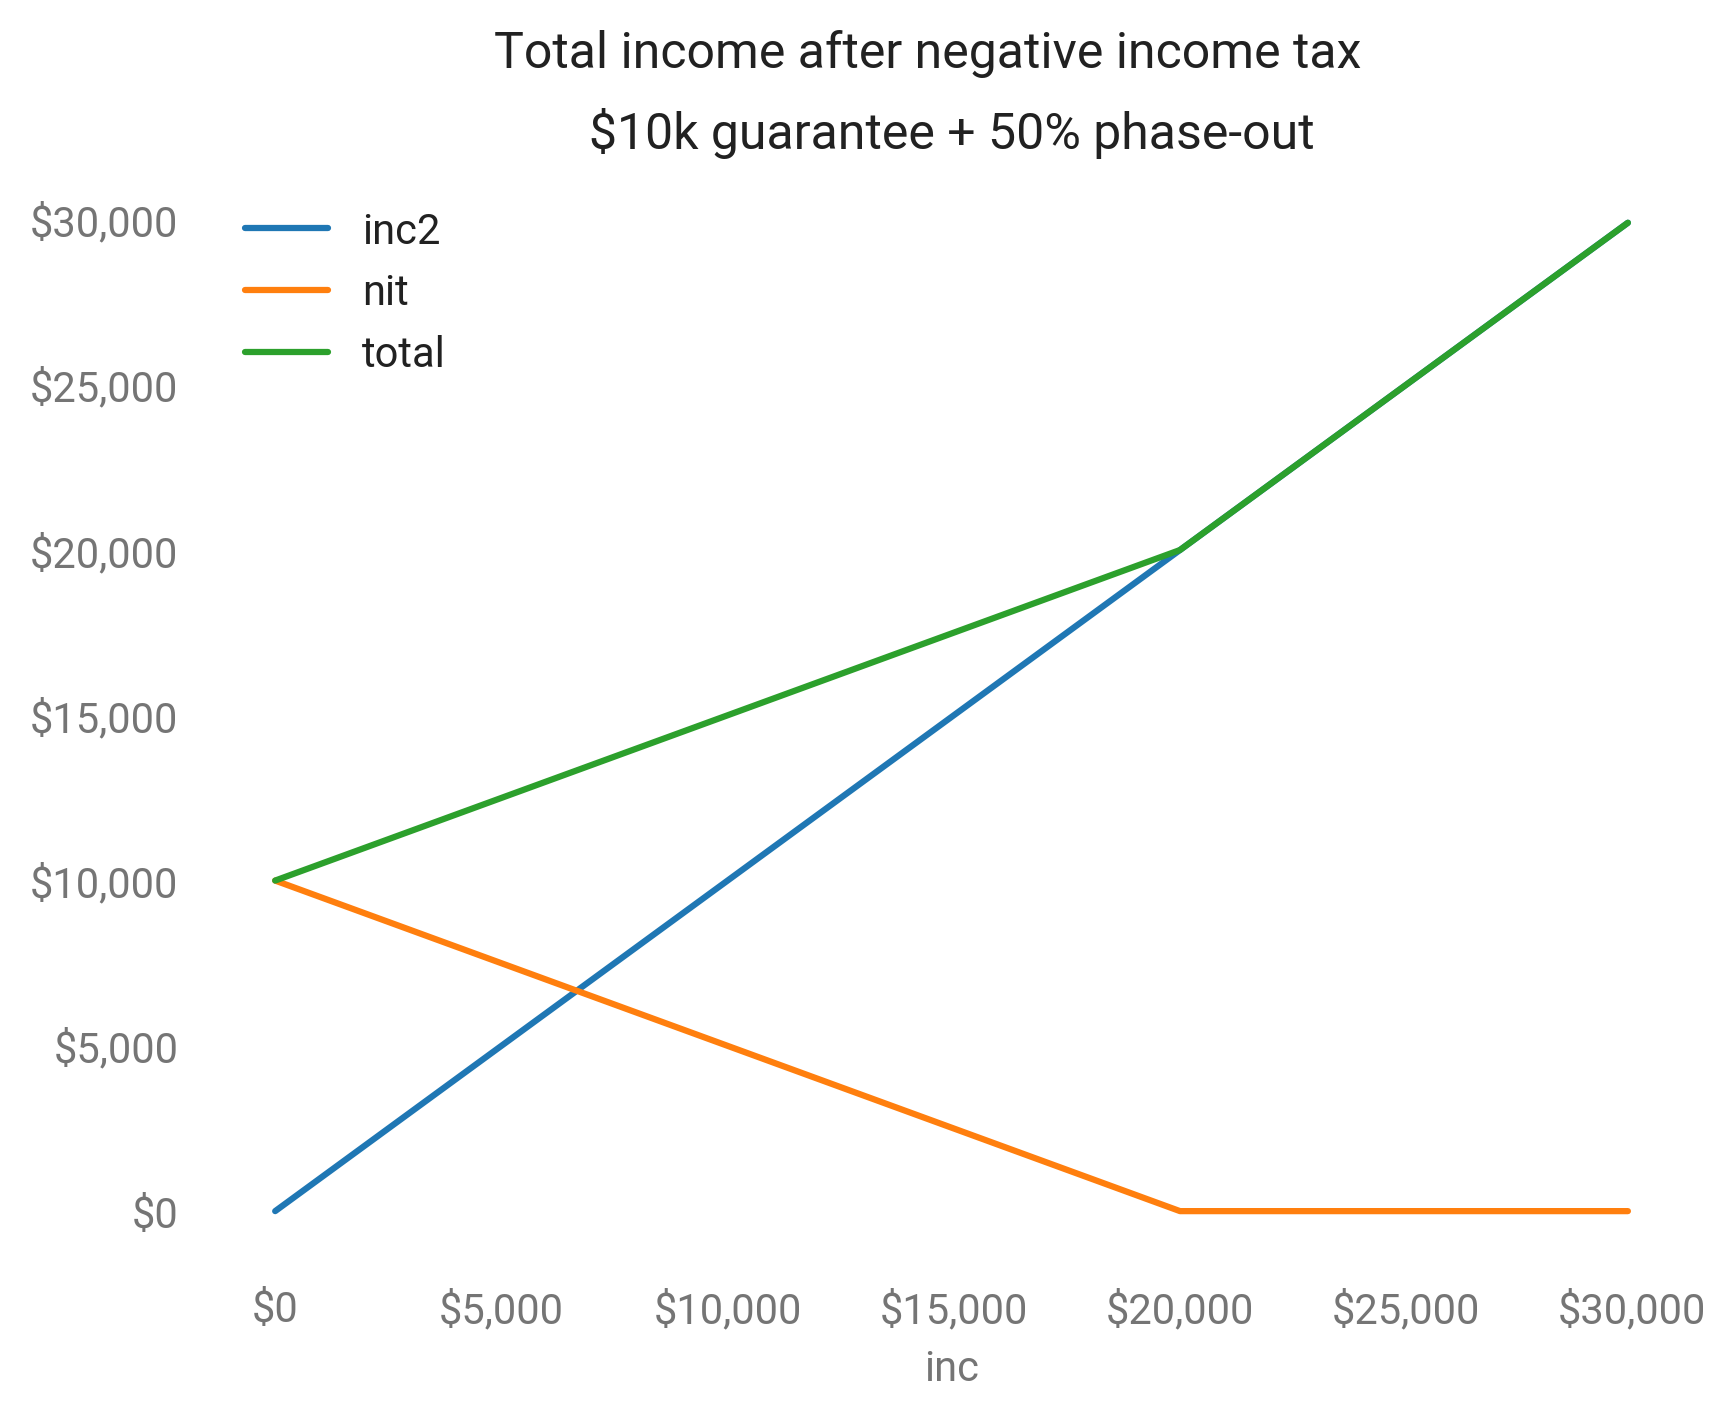

In [13]:
ax = demo.plot(x='inc', y=['inc2', 'nit', 'total'])
sns.despine(left=True, bottom=True)
plt.legend(frameon=False)
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))
plt.suptitle('Total income after negative income tax')
plt.title('$10k guarantee + 50% phase-out')

### Run on real data

In [14]:
def nit_total_b(df, guarantee, ps):
    return (phase_out(guarantee, ps, df.afti_pp) * df.XTOT_m).sum() / 1e3

In [15]:
nit_totals = pd.DataFrame({
    'guarantee': pd.Series(range(0, 150)) * 100
})

In [16]:
nit_totals['nit_total_b_50'] = nit_totals.apply(
    lambda x: nit_total_b(df, x.guarantee, 0.5), axis=1)
nit_totals['nit_total_b_33'] = nit_totals.apply(
    lambda x: nit_total_b(df, x.guarantee, 0.33), axis=1)

In [17]:
def XTOT_m_under_line(df, line):
    return df[df.afti_pp < line].XTOT_m.sum()

nit_totals['XTOT_m_under_line'] = nit_totals.apply(
    lambda x: XTOT_m_under_line(df, x.guarantee), axis=1)
nit_totals['XTOT_share_under_line'] = (
    nit_totals.XTOT_m_under_line / df.XTOT_m.sum())

In [18]:
nit_totals['cost_per_pov_50'] = (
    1000 * nit_totals.nit_total_b_50 / nit_totals.XTOT_m_under_line)
nit_totals['cost_per_pov_33'] = (
    1000 * nit_totals.nit_total_b_33 / nit_totals.XTOT_m_under_line)

In [19]:
nit_totals[nit_totals.guarantee == 7500]

,guarantee,nit_total_b_50,nit_total_b_33,XTOT_m_under_line,XTOT_share_under_line,cost_per_pov_50,cost_per_pov_33
75,7500,344.26,598.15,37.24,0.11,9243.23,16060.1


In [20]:
def dollar_axis(axis):
    axis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda x, p: '$' + format(int(x), ',')))

Text(0,1,'Cost of a negative income tax by per-person guaranteed income')

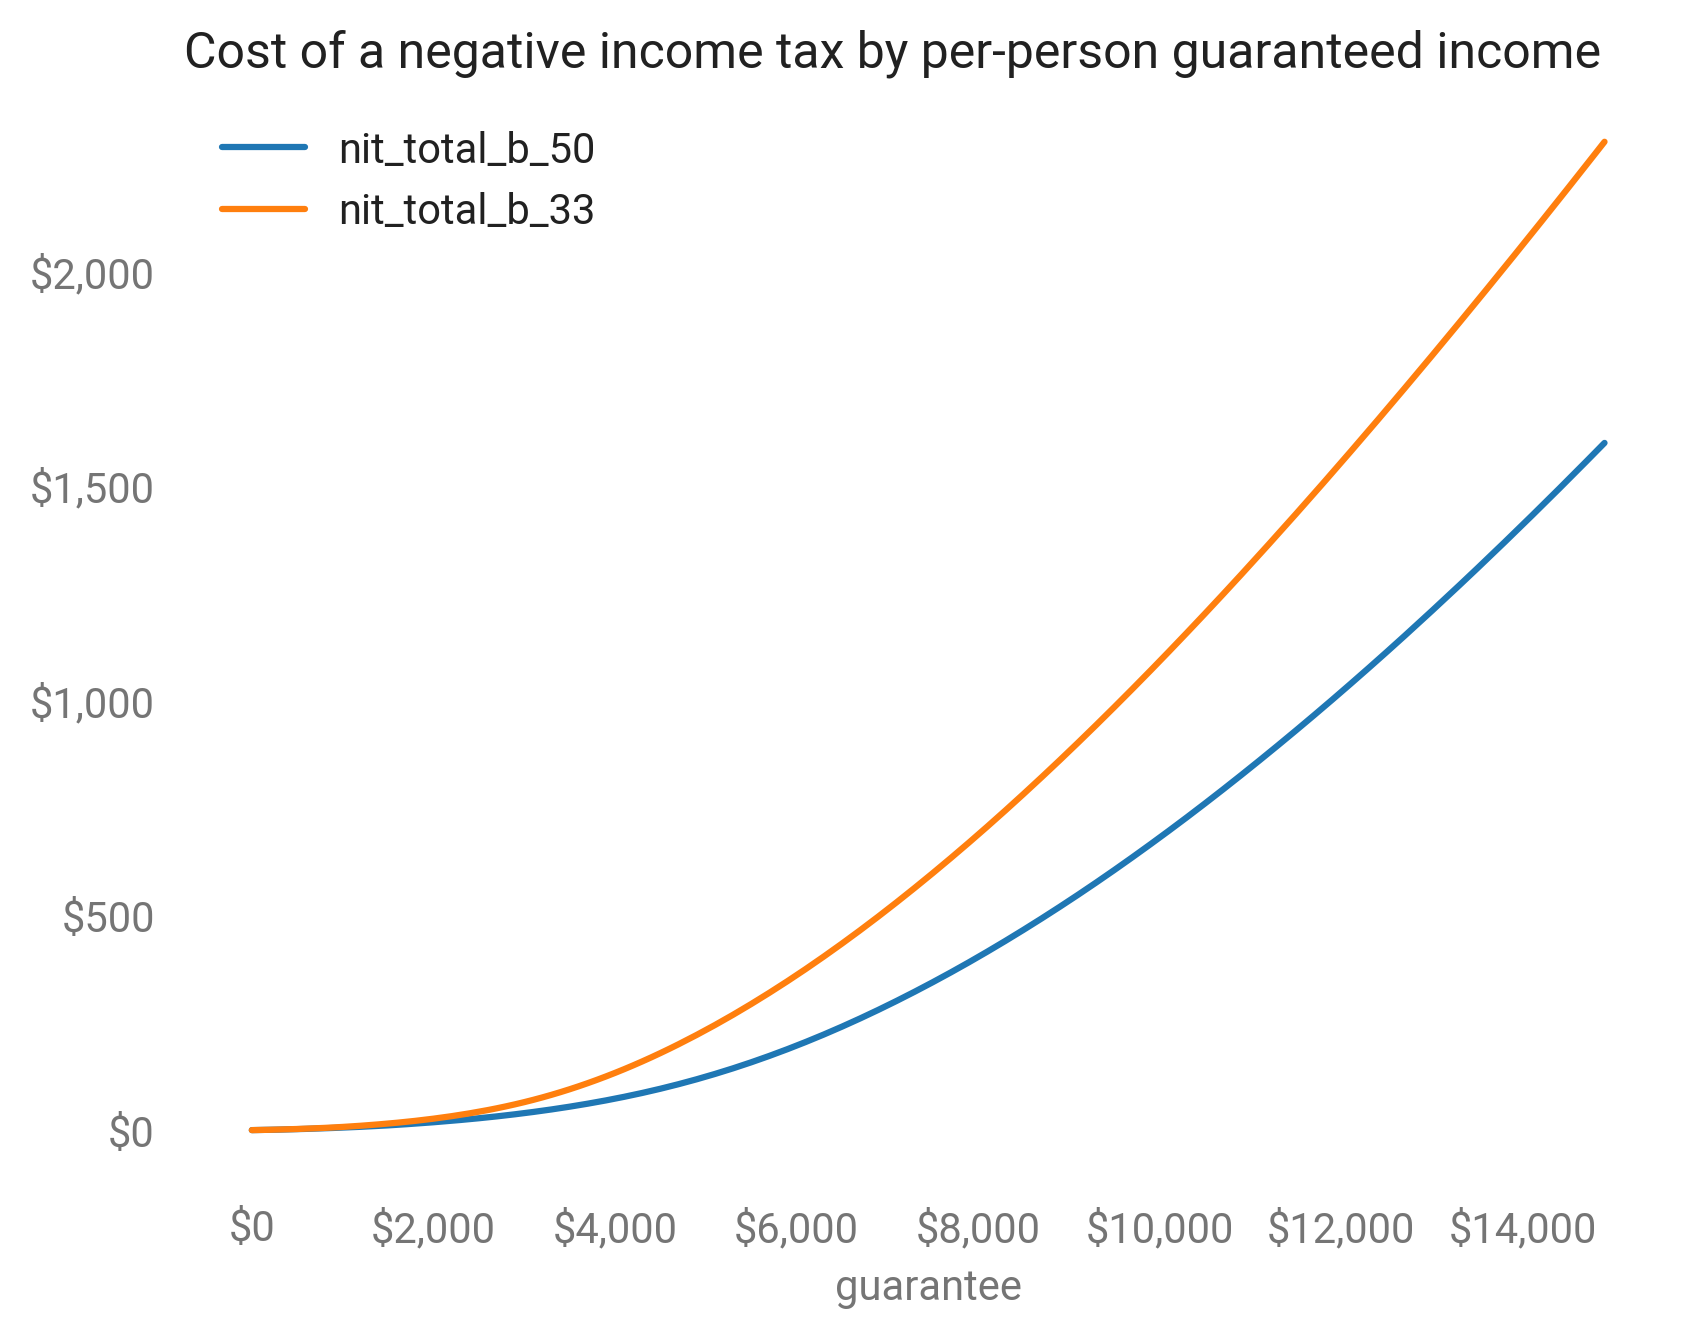

In [21]:
ax = nit_totals.plot(x='guarantee', y=['nit_total_b_50', 'nit_total_b_33'])
plt.legend(frameon=False)
sns.despine(left=True, bottom=True)
dollar_axis(ax.get_xaxis())
dollar_axis(ax.get_yaxis())
plt.title('Cost of a negative income tax by per-person guaranteed income', 
          loc='left')

In [22]:
JG_COST = 360.9
nit_totals[nit_totals.nit_total_b_50 < JG_COST].tail(2)

,guarantee,nit_total_b_50,nit_total_b_33,XTOT_m_under_line,XTOT_share_under_line,cost_per_pov_50,cost_per_pov_33
75,7500,344.26,598.15,37.24,0.11,9243.23,16060.10
76,7600,355.63,615.71,38.10,0.11,9333.16,16158.56


In [23]:
nit_totals[nit_totals.guarantee.isin([7500, 10000])]

,guarantee,nit_total_b_50,nit_total_b_33,XTOT_m_under_line,XTOT_share_under_line,cost_per_pov_50,cost_per_pov_33
75,7500,344.26,598.15,37.24,0.11,9243.23,16060.1
100,10000,681.13,1091.80,61.52,0.18,11072.30,17748.1


In [24]:
nit_totals.sample(5)

,guarantee,nit_total_b_50,nit_total_b_33,XTOT_m_under_line,XTOT_share_under_line,cost_per_pov_50,cost_per_pov_33
100,10000,681.13,1091.80,61.52,0.18,11072.30,17748.10
40,4000,73.23,133.15,16.57,0.05,4418.79,8033.71
49,4900,118.36,221.60,20.41,0.06,5798.47,10856.57
103,10300,728.32,1157.86,64.68,0.19,11261.24,17902.71
139,13900,1389.28,2035.00,102.55,0.31,13547.09,19843.59


### Cost per person lifted out of poverty

Text(0,1,'Cost per person lifted above line with a negative income tax at that line')

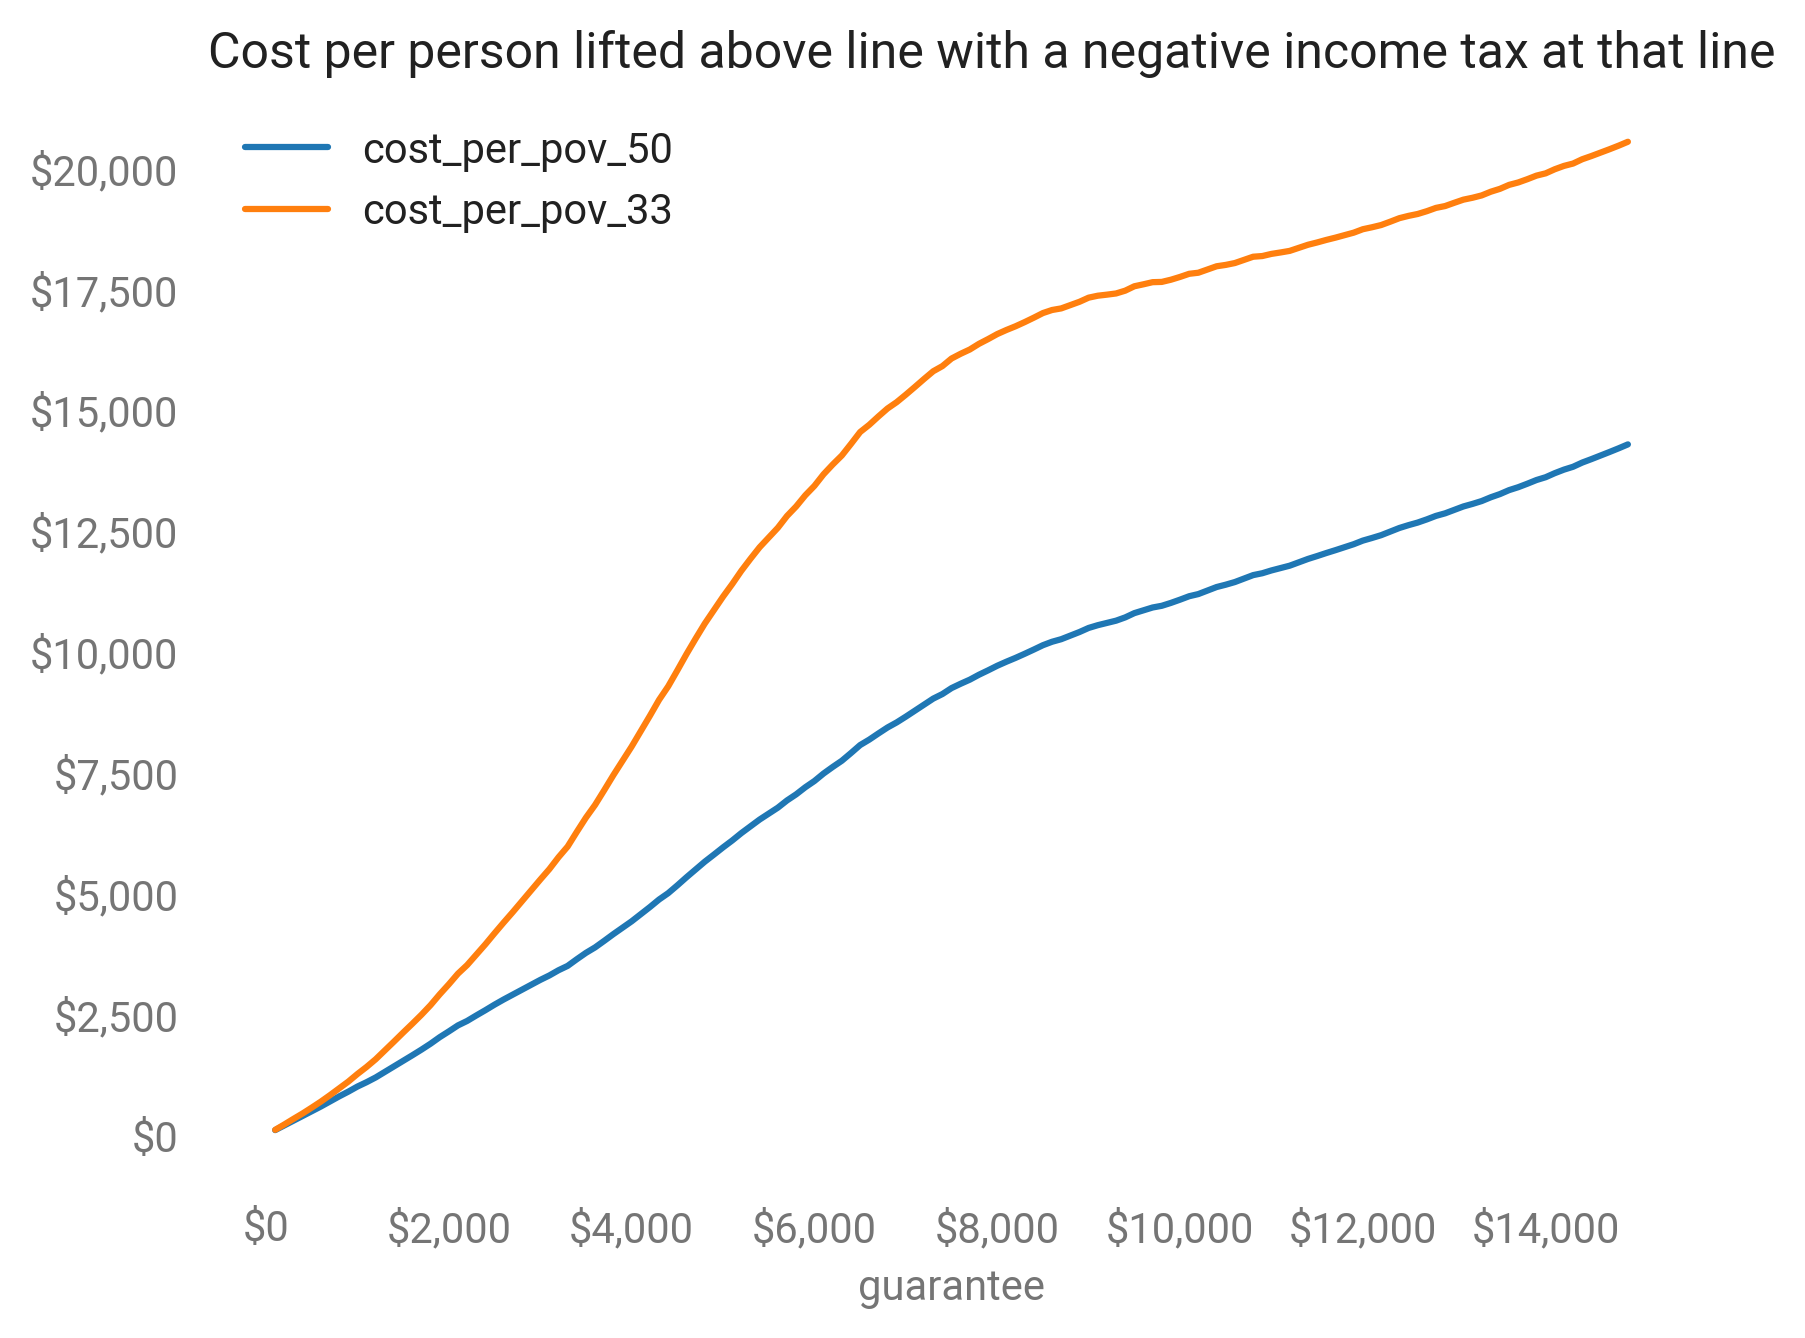

In [25]:
ax = nit_totals.plot(x='guarantee', y=['cost_per_pov_50', 'cost_per_pov_33'])
sns.despine(left=True, bottom=True)
plt.legend(frameon=False)
dollar_axis(ax.get_xaxis())
dollar_axis(ax.get_yaxis())
plt.title('Cost per person lifted above line with a negative income tax at that line',
          loc='left')

Text(0,1,'Share of people in tax units below income levels')

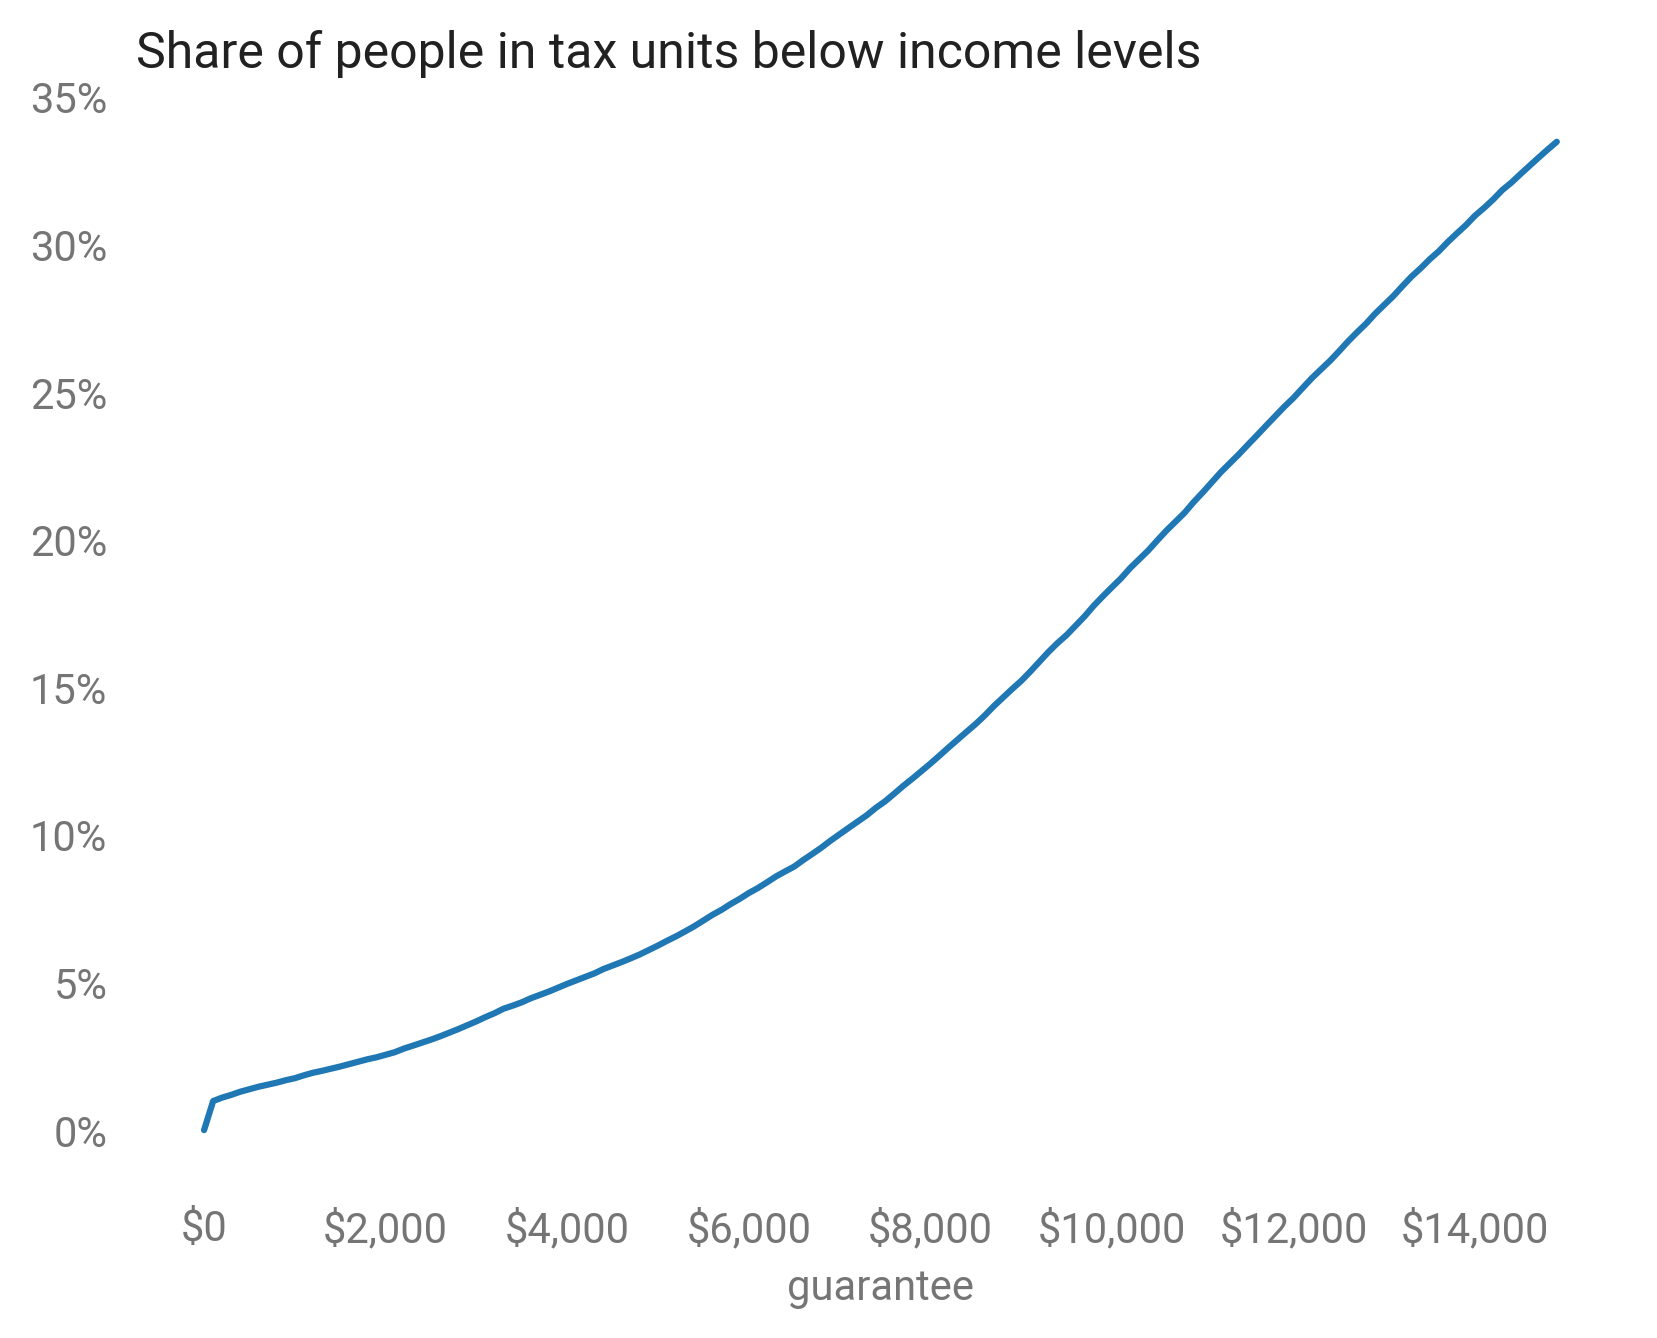

In [26]:
ax = nit_totals.plot(x='guarantee', y=['XTOT_share_under_line'])
ax.legend_.remove()
dollar_axis(ax.get_xaxis())
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: '{:.0%}'.format(y)))
sns.despine(left=True, bottom=True)
plt.title('Share of people in tax units below income levels', loc='left')